# CXR-ML-GZSL

## Overview

The goal of this notebook is to reproduce the findings of the paper, "Multi-Label Generalized Zero Shot Learning for the Classification of Disease in Chest Radiographs" with the help of an LLM. The paper provides code, which was a valuable reference during the development of this notebook.

* Paper: https://arxiv.org/abs/2107.06563
* Code: https://github.com/nyuad-cai/CXR-ML-GZSL

This notebook reuses the dataset training, validation, and test split provided by the original paper, as well as the pre-generated BioBERT text embeddings of the class names.

* Dataset split: https://github.com/nyuad-cai/CXR-ML-GZSL/tree/master/dataset_splits
* Class embeddings: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/embeddings/nih_chest_xray_biobert.npy

The paper uses a dataset, initially known as `ChestX-ray8`, but then renamed to `ChestX-ray14` when the dataset was expanded from eight to fourteen distinct disease labels. The dataset contains 112120 labeled chest X-rays.

* Dataset paper: https://arxiv.org/abs/1705.02315
* Dataset: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

The dataset provides an example of how to download the chext X-ray images and a spreadsheet mapping images to classification labels. However, the "dataset split" files already contain the image classification labels so this notebook does not use the spreadsheet.

* Download script: https://nihcc.app.box.com/v/ChestXray-NIHCC/file/371647823217
* Labels: https://nihcc.app.box.com/v/ChestXray-NIHCC/file/219760887468

**Note**: The dataset is ~42 GB. Expect significant download times.

**Note**: The notebook will request access to Google Drive to save training checkpoints. This is to avoid loosing training progress if Google Colab times out.

## Environment

In [1]:
!if command -v nvidia-smi &> /dev/null; then nvidia-smi --query-gpu=name --format=csv,noheader; else echo 'No NVIDIA GPU detected'; fi
!python --version

NVIDIA A100-SXM4-40GB
Python 3.11.12


In [22]:
import multiprocessing
import os
import requests
from statistics import mean
import tarfile
import time
import urllib.request

from google.colab import drive

import matplotlib
import matplotlib.pyplot as plt

print(f"matplotlib: {matplotlib.__version__}")

import numpy as np

print(f"numpy: {np.__version__}")

import pandas as pd
from pandas.plotting import table

print(f"pandas: {pd.__version__}")

import PIL
from PIL import Image

print(f"PIL: {PIL.__version__}")

import sklearn
from sklearn.metrics import roc_auc_score

print(f"sklearn: {sklearn.__version__}")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

print(f"torch: {torch.__version__}")

import torchvision
from torchvision import models
import torchvision.transforms as transforms

print(f"torchvision: {torchvision.__version__}")

import tqdm

print(f"tqdm: {tqdm.__version__}")

seed = 1002
torch.manual_seed(seed)
np.random.seed(seed)

matplotlib: 3.10.0
numpy: 2.0.2
pandas: 2.2.2
PIL: 11.1.0
sklearn: 1.6.1
torch: 2.6.0+cu124
torchvision: 0.21.0+cu124
tqdm: 4.67.1


## Download

In [3]:
for filename in ["train.txt", "val.txt", "test.txt"]:
    response = requests.get(f"https://raw.githubusercontent.com/nyuad-cai/CXR-ML-GZSL/master/dataset_splits/{filename}")

    with open(filename, "w") as f:
        f.write(response.text)

    print(f"Downloaded: {filename}")

Downloaded: train.txt
Downloaded: val.txt
Downloaded: test.txt


In [4]:
CLASS_EMBEDDINGS = "nih_chest_xray_biobert.npy"

response = requests.get(f"https://raw.githubusercontent.com/nyuad-cai/CXR-ML-GZSL/master/embeddings/{CLASS_EMBEDDINGS}")

with open(CLASS_EMBEDDINGS, "wb") as f:
    f.write(response.content)

print(f"Downloaded: {CLASS_EMBEDDINGS}")

Downloaded: nih_chest_xray_biobert.npy


In [5]:
dataset = [
    {"filename": "images_001.tar.gz", "url": "https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz"} #todo: Add the rest of the dataset
]

# dataset = [
#     {"filename": "images_001.tar.gz", "url": "https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz"},
#     {"filename": "images_002.tar.gz", "url": "https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz"},
#     {"filename": "images_003.tar.gz", "url": "https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz"},
#     {"filename": "images_004.tar.gz", "url": "https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz"},
#     {"filename": "images_005.tar.gz", "url": "https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz"},
#     {"filename": "images_006.tar.gz", "url": "https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz"},
#     {"filename": "images_007.tar.gz", "url": "https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz"},
#     {"filename": "images_008.tar.gz", "url": "https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz"},
#     {"filename": "images_009.tar.gz", "url": "https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz"},
#     {"filename": "images_010.tar.gz", "url": "https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz"},
#     {"filename": "images_011.tar.gz", "url": "https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz"},
#     {"filename": "images_012.tar.gz", "url": "https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz"},
# ]

for item in dataset:
    filename = item["filename"]
    url = item["url"]

    urllib.request.urlretrieve(url, filename)

    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()

    os.remove(filename)

    print(f"Downloaded and extracted: {filename}")

IMAGE_PATH = "images"

assert os.path.exists(IMAGE_PATH), "Dataset is not in the expected directory!"

Downloaded and extracted: images_001.tar.gz


## Preprocessing

In [6]:
class ChestXrayDataset(Dataset):
    def __init__(self, image_dir, labels_file, transform, excluded_classes=None):
        self.image_dir = image_dir
        self.transform = transform
        self.data = []

        with open(labels_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                image_name = os.path.basename(parts[0])
                labels = list(map(int, parts[1:]))

                if all(l == 0 for l in labels):
                    continue

                if excluded_classes is not None and any(labels[i] == 1 for i in excluded_classes):
                    continue

                if not os.path.isfile(f"{self.image_dir}/{image_name}"): #todo: Remove once we add the full database
                    continue

                self.data.append((image_name, torch.tensor(labels, dtype=torch.int64)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, labels = self.data[idx]
        image_path = os.path.join(self.image_dir, image_name)

        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        return image, labels

**Note**: The validation dataset is not for tuning hyperparameters, but to measure the training loss. Cross-validation is not used.

In [7]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/ChexnetTrainer.py#L104-L130
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/arguments.py#L22-L23

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

training_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

testing_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
])

train_data = ChestXrayDataset(IMAGE_PATH, "train.txt", transform=training_transform, excluded_classes=[10, 11, 12, 13])
val_data   = ChestXrayDataset(IMAGE_PATH, "val.txt",   transform=testing_transform,  excluded_classes=[10, 11, 12, 13])
test_data  = ChestXrayDataset(IMAGE_PATH, "test.txt",  transform=testing_transform)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Testing samples: {len(test_data)}")

train_loader = DataLoader(train_data, batch_size=16,    shuffle=True,  num_workers=multiprocessing.cpu_count(), pin_memory=True)
val_loader   = DataLoader(val_data,   batch_size=16*10, shuffle=False, num_workers=multiprocessing.cpu_count(), pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=16*3,  shuffle=False, num_workers=multiprocessing.cpu_count(), pin_memory=True)

Training samples: 1246
Validation samples: 142
Testing samples: 506


## Model

In [8]:
class ML_GZSL(nn.Module):
    def __init__(self, embedding_path, gamma1, gamma2, delta):
        super(ML_GZSL, self).__init__()
        self.gamma1 = gamma1
        self.gamma2 = gamma2
        self.delta = delta

        # Load class name embeddings as a buffer so it moves with the model
        self.register_buffer("class_embeddings", torch.tensor(np.load(embedding_path), dtype=torch.float32))  # (14, 1024)

        # Visual encoder: Densenet-121 without classification head
        self.visual_encoder = models.densenet121(weights=None)
        self.visual_encoder.classifier = nn.Identity()
        visual_out_dim = 1024

        # Visual mapping module
        self.visual_mapping = nn.Sequential(
            nn.Linear(visual_out_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

        # Semantic mapping module
        self.semantic_mapping = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x, labels):
        batch_size, num_crops, C, H, W = x.shape
        x = x.view(-1, C, H, W)

        visual_features = self.visual_encoder(x)
        visual_features = self.visual_mapping(visual_features)
        visual_features = visual_features.view(batch_size, num_crops, -1).mean(dim=1)

        semantic_features = self.semantic_mapping(self.class_embeddings)

        relevance_scores = F.cosine_similarity(
            visual_features.unsqueeze(1),
            semantic_features.unsqueeze(0),
            dim=-1
        )

        # Ranking Loss
        loss_rank = 0
        for i in range(batch_size):
            y_true = labels[i]
            pos_idx = (y_true == 1).nonzero(as_tuple=True)[0]
            neg_idx = (y_true == 0).nonzero(as_tuple=True)[0]
            for pos in pos_idx:
                for neg in neg_idx:
                    pos_score = relevance_scores[i, pos]
                    neg_score = relevance_scores[i, neg]
                    loss_rank += F.relu(self.delta + neg_score - pos_score)
        loss_rank /= (batch_size * labels.size(1))

        # Alignment Loss
        wx_list = []
        for i in range(batch_size):
            y_true = labels[i]
            pos_idx = (y_true == 1).nonzero(as_tuple=True)[0]
            if len(pos_idx) > 0:
                avg_sem = self.class_embeddings[pos_idx].mean(dim=0)
                avg_sem_proj = self.semantic_mapping(avg_sem)
                cos_sim = F.cosine_similarity(visual_features[i], avg_sem_proj, dim=0)
                wx_list.append(1 - cos_sim)
        loss_align = torch.stack(wx_list).mean() if wx_list else torch.tensor(0.0, device=x.device)

        # Consistency Loss
        orig_sim = F.cosine_similarity(
            self.class_embeddings.unsqueeze(1),
            self.class_embeddings.unsqueeze(0),
            dim=-1
        )
        proj_sim = F.cosine_similarity(
            semantic_features.unsqueeze(1),
            semantic_features.unsqueeze(0),
            dim=-1
        )
        loss_con = F.l1_loss(orig_sim, proj_sim)

        total_loss = loss_rank + self.gamma1 * loss_align + self.gamma2 * loss_con

        return relevance_scores, total_loss

## Training

In [15]:
DRIVE_PATH = '/content/drive'

if not os.path.ismount(DRIVE_PATH):
    drive.mount(DRIVE_PATH)

checkpoint_path = f"{DRIVE_PATH}/MyDrive/ml_gzsl_checkpoint.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ML_GZSL(CLASS_EMBEDDINGS, gamma1=0.1, gamma2=0.1, delta=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=10)

start_epoch = 0
best_val_auroc = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    scheduler.load_state_dict(checkpoint['scheduler_state'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_auroc = checkpoint['best_val_auroc']
    print(f"Resuming from epoch {start_epoch} with best val AUROC {best_val_auroc:.4f}")

# Training loop
for epoch in range(start_epoch, 15): #todo: Update to 100
    model.train()
    start_time = time.time()
    for images, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch}"):
        images = images.unsqueeze(1).to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        _, loss = model(images, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()
            preds, loss = model(images, labels)
            val_loss += loss.item() * images.size(0)
            all_preds.append(preds[:, :-4].cpu())
            all_labels.append(labels[:, :-4].cpu())

    val_loss /= len(val_loader.dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    val_auroc = roc_auc_score(all_labels.numpy(), all_preds.numpy(), average='macro')
    scheduler.step(val_loss)

    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'best_val_auroc': best_val_auroc
        }, checkpoint_path)

    runtime = time.time() - start_time
    print(f"Epoch {epoch}: Time={runtime:.2f}s, Val Loss={val_loss:.4f}, Val AUROC={val_auroc:.4f}")

Resuming from epoch 14 with best val AUROC 0.6261


Epoch 14: 100%|██████████| 78/78 [00:15<00:00,  5.11it/s]


Epoch 14: Time=21.88s, Val Loss=0.2608, Val AUROC=0.5350


## Evaluation

In [18]:
# Set model to eval mode and move to the correct device
model.eval()
model.to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device).float()
        preds, _ = model(images, labels)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Compute AUROC for each class
auroc_per_class = []
for i in range(14):
    try:
        auroc = roc_auc_score(all_labels[:, i], all_preds[:, i])
    except ValueError:
        auroc = float('nan')  # If only one class present in labels
    auroc_per_class.append(auroc)

Testing: 100%|██████████| 11/11 [00:07<00:00,  1.48it/s]

Class 0: AUROC = 0.4783
Class 1: AUROC = 0.3966
Class 2: AUROC = 0.5636
Class 3: AUROC = 0.5751
Class 4: AUROC = 0.5959
Class 5: AUROC = 0.6177
Class 6: AUROC = 0.6351
Class 7: AUROC = 0.4645
Class 8: AUROC = 0.6477
Class 9: AUROC = 0.7115
Class 10: AUROC = 0.6946
Class 11: AUROC = 0.5481
Class 12: AUROC = 0.4870
Class 13: AUROC = 0.3565


## Results

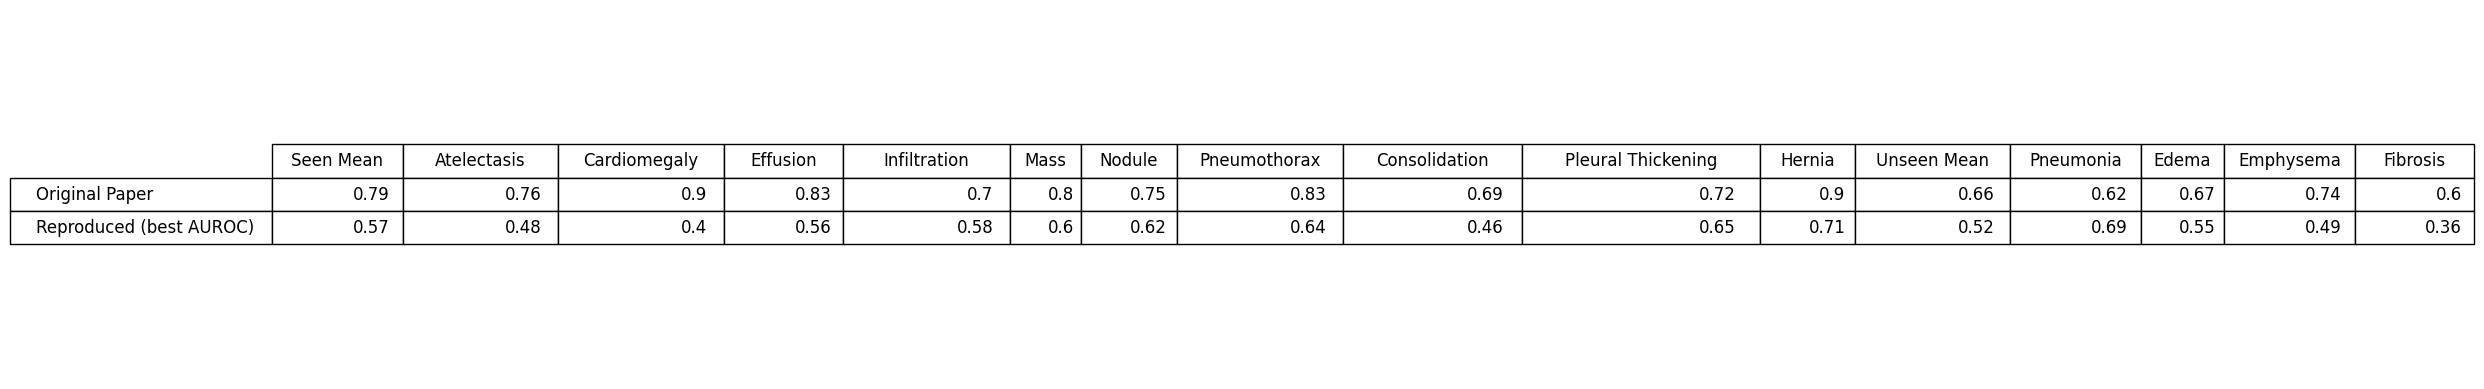

In [23]:
# Credit: https://github.com/nyuad-cai/CXR-ML-GZSL/blob/master/images/results2.png

results = {
    "Original Paper": {
        "Seen Mean":          0.79,
        "Atelectasis":        0.76,
        "Cardiomegaly":       0.90,
        "Effusion":           0.83,
        "Infiltration":       0.70,
        "Mass":               0.80,
        "Nodule":             0.75,
        "Pneumothorax":       0.83,
        "Consolidation":      0.69,
        "Pleural Thickening": 0.72,
        "Hernia":             0.90,
        "Unseen Mean":        0.66,
        "Pneumonia":          0.62,
        "Edema":              0.67,
        "Emphysema":          0.74,
        "Fibrosis":           0.60
    }
}

results["Reproduced (best AUROC)"] = {
        "Seen Mean":          mean(auroc_per_class[:10]),
        "Atelectasis":        auroc_per_class[0],
        "Cardiomegaly":       auroc_per_class[1],
        "Effusion":           auroc_per_class[2],
        "Infiltration":       auroc_per_class[3],
        "Mass":               auroc_per_class[4],
        "Nodule":             auroc_per_class[5],
        "Pneumothorax":       auroc_per_class[6],
        "Consolidation":      auroc_per_class[7],
        "Pleural Thickening": auroc_per_class[8],
        "Hernia":             auroc_per_class[9],
        "Unseen Mean":        mean(auroc_per_class[10:]),
        "Pneumonia":          auroc_per_class[10],
        "Edema":              auroc_per_class[11],
        "Emphysema":          auroc_per_class[12],
        "Fibrosis":           auroc_per_class[13]
}

df = pd.DataFrame(results).T.round(2)

fig, ax = plt.subplots()
ax.axis('off')

tbl = table(ax, df, loc='center', colWidths=[ 0.02 * (len(col)+2) for col in df.columns.tolist() ])
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 2)

plt.show()